In [3]:
MATCH_TO_EXAMINE = '2023-wimbledon-1701'

In [8]:
import numpy as np
import pandas as pd

import tennis_data
import dynamic_model1 as dm1

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_context('notebook')
plt.style.use('ggplot')

In [10]:
p = 0.50
dm1.prob_win_match(dm1.prob_win_set(dm1.prob_hold(p)))

0.01888208513455345

In [101]:
# 1 - Calculate serve probability (points_on_serves / total serves)
# 2 - Calculate probability of winning a game from serve probability for each player
# 3 - Calculate probability of winning a set from the player win game probability
# 4 - Calculate probability of winning a match from the player win set probability
# 5 - Graph the probability of winning the set as point values increase

In [11]:
wimbledon_data_raw = pd.read_csv(tennis_data.DATA_FOLDER+'2023-wimbledon-data.csv')

alcaraz_match = wimbledon_data_raw[wimbledon_data_raw['match_id'] == MATCH_TO_EXAMINE]

player1_name = alcaraz_match['player1'].values[0]
player2_name = alcaraz_match['player2'].values[0]

In [15]:
# 1 - Get serve probabilities

p1_probability = dm1.get_serve_probability(alcaraz_match, 1)
p2_probability = dm1.get_serve_probability(alcaraz_match, 2)

#print("Probability of winning a serve")
#print(p1_probability)
#print(p2_probability)

#  2 - Get probability of winning the game

max_length = max(len(p1_probability), len(p2_probability))

pg1_array = []
pg2_array = []

for index in range(max_length):
    pg1, pg2 = dm1.prob_win_independent_game(p1_probability[index], p2_probability[index])

    pg1_array.append(pg1)
    pg2_array.append(pg2)

#print("Probability of winning the game")
#print(pg1_array)
#print(pg2_array)


# 3 - Get probability of winning the set.

ps1_array = []
ps2_array = []

for index in range(max_length):
    ps1_array.append(dm1.prob_win_set(pg1_array[index]))
    ps2_array.append(dm1.prob_win_set(pg2_array[index]))

#print("Probability of winning the set")

#print(ps1_array)
#print(ps2_array)


# 4 - Get probability of winning the match

pm1_array = []
pm2_array = []

for index in range(max_length):
    pm1_array.append(dm1.prob_win_match(ps1_array[index]))
    pm2_array.append(dm1.prob_win_match(ps2_array[index]))

#print("Probability of winning the match")

#print(pm1_array)
#print(pm2_array)

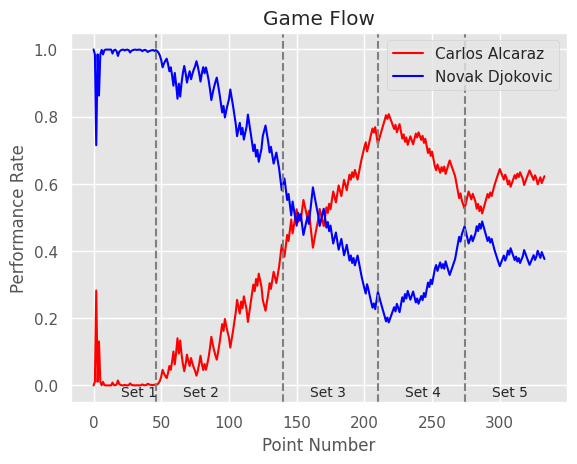

In [16]:
set_change_points = []

old_entry = 1
for index, entry in enumerate(alcaraz_match['set_no']):
    if entry != old_entry:
        set_change_points.append(index + 1)
        old_entry = entry

plt.title("Game Flow")
plt.plot(range(len(pm1_array)), pm1_array, color="red", label=f"{player1_name}")
plt.plot(range(len(pm2_array)), pm2_array, color="blue", label=f"{player2_name}")
plt.xlabel("Point Number")
plt.ylabel("Performance Rate")
plt.legend()

plt.text(20, -.04, 'Set 1', verticalalignment='bottom')
for index, value in enumerate(set_change_points):
    plt.axvline(x=value, color='gray', linestyle='--')
    plt.text(value + 20, -.04, f"Set {index + 2}", verticalalignment='bottom')

plt.show()

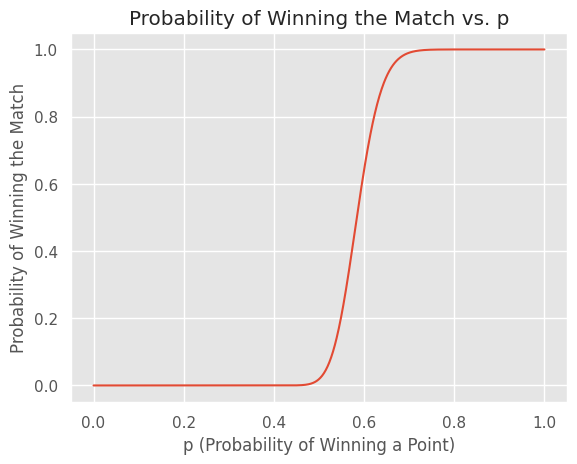

In [18]:
p_values = [i/1000 for i in range(1001)]  # Values between 0 and 1 with step 0.01

# Calculate pm1_array for each p value
pm1_array = []
for p_value in p_values:
    pm1_array.append(dm1.prob_win_match(dm1.prob_win_set(dm1.prob_hold(p_value))))
    
# Plot pm1_array against p_values
plt.plot(p_values, pm1_array)
plt.xlabel('p (Probability of Winning a Point)')
plt.ylabel('Probability of Winning the Match')
plt.title('Probability of Winning the Match vs. p')
plt.grid(True)
plt.show()

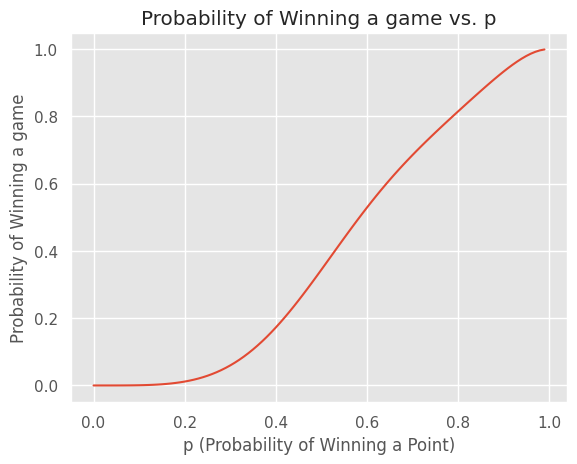

In [20]:
p_values = np.arange(0,1,0.01)  # Values between 0 and 1 with step 0.01

# Calculate pm1_array for each p value
pm1_array = []
for p_value in p_values:
    pm1_array.append(dm1.prob_hold(p_value))

# Plot pm1_array against p_values
plt.plot(p_values, pm1_array)
plt.xlabel('p (Probability of Winning a Point)')
plt.ylabel('Probability of Winning a game')
plt.title('Probability of Winning a game vs. p')
plt.grid(True)
plt.show()